In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.models import Model, Sequential
import pandas as pd
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [2]:
def plot_loss(history, title):
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: ' + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    print('MSE val = ', history.history['val_loss'][-1])

In [3]:
def plot_y_yhat(x_test, y_test, model, title,scale):
#y_pred = model.predict(X_test)
    y_hat = model.predict(x_test)
    Time_test = np.arange(0, len(y_hat))
    plt.figure(1)
    plt.figure(figsize=(20,10))
    plt.plot(Time_test, y_hat*scale, '-+', Time_test, y_test*scale)
    plt.legend(['Predicted', 'True'], loc='upper right')
    plt.title('Y vs Yhat: ' + title)
    results = model.evaluate(x_test, y_test)
    print("test loss, test acc:", results)

In [4]:
#Getting Data from CSV
rona = pd.read_csv("Data/US_covid_daily.csv")

In [5]:
rona

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,1/22/2020,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,1,0
1,1/23/2020,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,1
2,1/24/2020,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
3,1/25/2020,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
4,1/26/2020,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,11/13/2020,235632.0,1304,26997.0,13132.0,3476,68519.0,511946.0,133266061,1214969,2967.0,3769.0,10588102,171376,4095387.0,56,164039849,1683680
297,11/14/2020,236956.0,1324,27172.0,13337.0,3547,69463.0,515493.0,134448227,1182166,2972.0,3945.0,10752950,164848,4148505.0,56,165716616,1676767
298,11/15/2020,237636.0,680,27269.0,13691.0,2007,69980.0,517500.0,135611240,1163013,2975.0,3932.0,10898532,145582,4185549.0,56,167334994,1618378
299,11/16/2020,238217.0,581,27437.0,14313.0,3070,73014.0,520570.0,136714600,1103360,2988.0,4157.0,11047064,148532,4244811.0,56,168814292,1479298


In [6]:
x= rona["positiveIncrease"].values

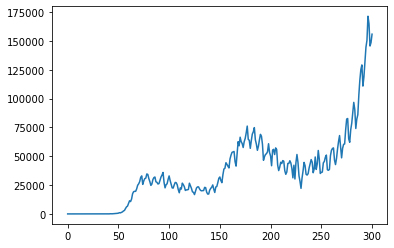

In [7]:
plt.plot(x)
plt.yscale("linear")
plt.show()

In [8]:
train_size = int(len(x) * 0.8)
test_size = len(x) - train_size
train = x[:train_size]
test = x[train_size:]

train = train.reshape(-1,1)
test = test.reshape(-1,1)
print(train.shape, test.shape)

# simple scaling
s1 = np.max(train)
s2 = np.max(test)
train = train/s1
test = test/s2

(240, 1) (61, 1)


In [9]:
time_steps = 10
n = 3 # prediction y(t+n) ahead


# Train sets
m_train = len(train)
target = np.roll(train,1-n)
dataset = TimeseriesGenerator(train, target , length=time_steps, batch_size = m_train-time_steps-n)
X_train, y_train = dataset[0]
print('X_train and y_train shapes: ', [X_train.shape, y_train.shape])

# Test sets
target = np.roll(test,1-n)
m_test = len(test)
dataset = TimeseriesGenerator(test, target , length=time_steps, batch_size = m_test-time_steps-n)
X_test, y_test = dataset[0]
print('X_test and y_test shapes: ', [X_test.shape, y_test.shape])

X_train and y_train shapes:  [(227, 10, 1), (227, 1)]
X_test and y_test shapes:  [(48, 10, 1), (48, 1)]


In [10]:
m = len(y_train)
nx = 1 # dim of x<t>
print('m, time_steps, n = look_ahead, nx: ', m, time_steps, n, nx)


m, time_steps, n = look_ahead, nx:  227 10 3 1


In [11]:
# RNN #
hidden_neurons = 120
model = Sequential()
model.add(SimpleRNN(units=hidden_neurons, input_shape=(time_steps, nx)))
model.add(Dense(units=200,activation='relu'))
model.add(Dense(units=1, activation=None))
opt=keras.optimizers.Adam()

model.compile(loss='mean_squared_error',optimizer=opt, metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 120)               14640     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               24200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 39,041
Trainable params: 39,041
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 204 samples, validate on 23 samples
Epoch 1/150
204/204 [==============================] - 0s 838us/step - loss: 0.0314 - accuracy: 0.1324 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 2/150
204/204 [==============================] - 0s 122us/step - loss: 0.0252 - accuracy: 0.1324 - val_loss: 0.0199 - val_accuracy: 0.0000e+00
Epoch 3/150
204/204 [==============================] - 0s 127us/step - loss: 0.0175 - accuracy: 0.1324 - val_loss: 0.0450 - val_accuracy: 0.0000e+00
Epoch 4/150
204/204 [==============================] - 0s 132us/step - loss: 0.0181 - accuracy: 0.1324 - val_loss: 0.0368 - val_accuracy: 0.0000e+00
Epoch 5/150
204/204 [==============================] - 0s 132us/step - loss: 0.0363 - accuracy: 0.1275 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 6/150
204/204 [==============================] - 0s 127us/step - loss: 0.0200 - accuracy: 0.1324 - val_loss: 0.0171 - val_accuracy: 0.0000e+00
Epoch 7/150
204/204 [==============================] - 0s 132

204/204 [==============================] - 0s 127us/step - loss: 0.0018 - accuracy: 0.1324 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 110/150
204/204 [==============================] - 0s 129us/step - loss: 0.0018 - accuracy: 0.1324 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 111/150
204/204 [==============================] - 0s 127us/step - loss: 0.0018 - accuracy: 0.1324 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 112/150
204/204 [==============================] - 0s 122us/step - loss: 0.0017 - accuracy: 0.1324 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 113/150
204/204 [==============================] - 0s 128us/step - loss: 0.0020 - accuracy: 0.1324 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 114/150
204/204 [==============================] - 0s 127us/step - loss: 0.0021 - accuracy: 0.1324 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 115/150
204/204 [==============================] - 0s 122us/step - loss: 0.0016 - accuracy: 0.1324 - v

# Comparing Accuracy with Test Data

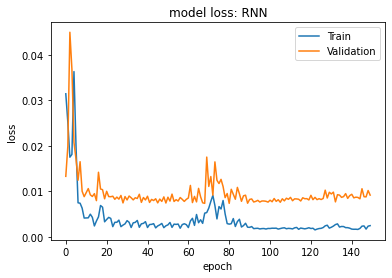

MSE val =  0.009158847732064516
48/48 [==============================] - 0s 41us/step
test loss, test acc: [0.0022271572767446437, 0.02083333395421505]


<Figure size 432x288 with 0 Axes>

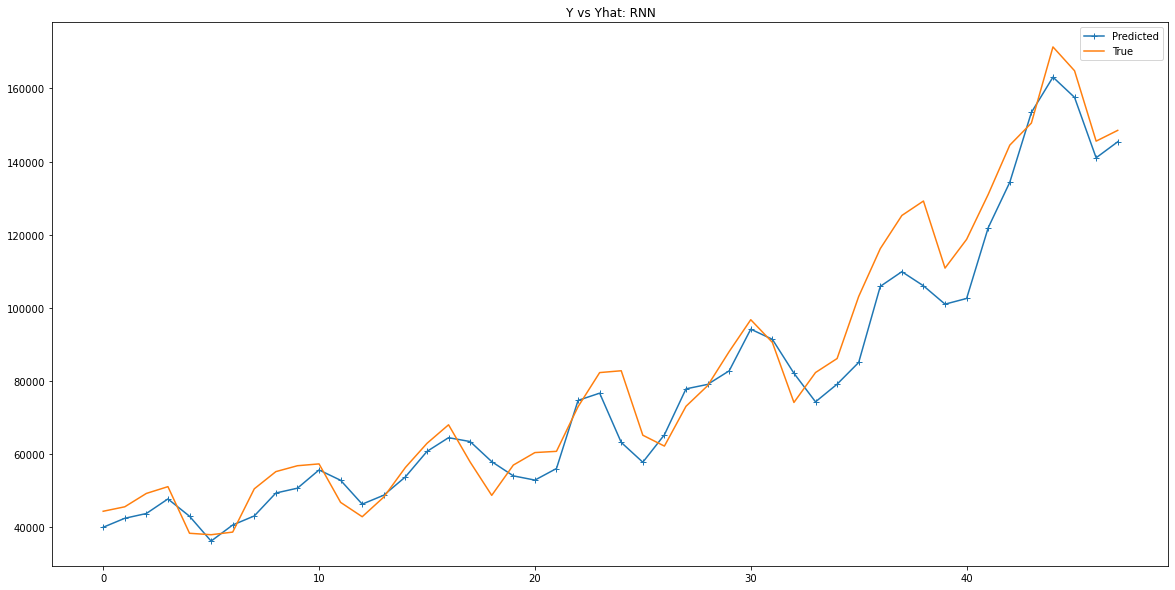

In [13]:
plot_loss(history, 'RNN')
#Added the s2 at the end to scale up
plot_y_yhat(X_test, y_test, model, 'RNN',s2)